In [1]:
# python
import os, sys, pickle
from collections import OrderedDict
from itertools import combinations_with_replacement

# stats
import numpy as np
import pandas as pd
from statsmodels.api import OLS
from scipy.stats import pearsonr, spearmanr


# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# neural networks
import torch, torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

# thesis library
from lib.functions_base_analysis        import *
from lib.functions_second_analysis      import *
from lib.ImageDataset                   import ImageDataset
from lib.NetworkScorer                  import NetworkScorer
from lib.PatternGenerator               import Pattern_Generator
from lib.ActivationPattern              import Activation_Pattern
from lib.transforms                     import VisualPriorRepresentation
from lib.PatternGeneratorSearchlight    import PatternGeneratorSearchlight

DATASET_NAMES               = ('places1', 'places2', 'oasis')
SCALE_NAMES                 = ('scale2','scale4','scale8','scale16','scale32')
STUDY_NAMES                 = ("short presentation", "long presentation", "complexity order")
BEHAVIOUR_NAMES             = ('study1_places1_short.csv','study2_places1.csv','study3_places2.csv','study4_oasis.csv')

PATH_IMAGES                 = '../images and ratings/imageversions_256'
PATH_RATINGS                = '../images and ratings/ratings'
PATH_INTEGRATION_VALUES     = '../data csv/integration' # !! correlations, invert sign for integration
PATH_IB_CORRELATIONS        = '../data csv/ibcorr'
PATH_IB_CORRELATIONS_BLOCKED= '../data csv/ibcorr blocked'

PATH_RESULTS                = '../results'
PATH_PLOTS                  = '../plots'

#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')

In [4]:
#DATA_PATH = './data_256x256'
#BEHAVIOR_PATH = './behavior'
#RESULTS_PATH = './data_integration_taskonomy'

# create folder structure

In [ ]:
# create folder structure for imageversions
for dataset_name in DATASET_NAMES:
    for scale_name in SCALE_NAMES:
        for version_name in ('full','version1','version2'):
            os.makedirs(os.path.join(PATH_IMAGES, dataset_name, scale_name, version_name))

In [ ]:
# create folder structure for results
for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:
            dir_path = os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name)
            os.makedirs(dir_path)

In [ ]:
# create folder strucutre for Pytorch -> Matlab converted results
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'ibcorr', model_name))

for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'ibcorr blocked', model_name))

for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'integration', model_name))

In [ ]:
# create folder strucutre for Matlab -> Python converted results (analysis results)
STUDY_NAMES = ('short presentation','long presentation','complexity order','oasis')

for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            os.makedirs(os.path.join(PATH, model_name, study_name, scale_name))


# main analysis: part-whole correlations taskonomy 

In [ ]:
for model_name in MODEL_NAMES:
    print(model_name)

    # Import taskonomy model...
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]
    
    # ...and create activation extractor from it
    _, eval_nodes = get_graph_node_names(net)
    return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    activation_extractor = create_feature_extractor(net, return_nodes=return_nodes)


    for dataset_name in DATASET_NAMES:
        print(dataset_name)

        for scale_name in SCALE_NAMES:
            
            dataset = ImageDataset(
                os.path.join(PATH_IMAGES, dataset_name, scale_name))
                        
            correlations, selfsimilarity, l2norm = calculate_dataset_metrics(dataset, activation_extractor)
            
            correlations.fillna(correlations.mean())
            selfsimilarity.fillna(selfsimilarity.mean())
            l2norm.fillna(l2norm.mean())
            
            correlations.to_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name, 'correlations.csv'), index=False, header=False)
            selfsimilarity.to_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            l2norm.to_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# load integration

In [215]:
# load results
data_list = []


for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name, 'correlations.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'dataset',dataset_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# convert correlation to integration
df = - pd.concat(data_list).set_index(['model','dataset','scale'])

In [ ]:
# block layers
df = df.T.set_index(np.insert(np.repeat(range(2,17+1), 3), 0, 1)).T.groupby(level=0,axis=1).mean()
df

In [ ]:
handles, labels = df.loc['autoencoding'].groupby('scale').mean().transpose().plot().get_legend_handles_labels()
order = [1, 3, 4, 0, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.25, 1.4))

# load ibcorr

In [13]:
#ib_list, ss_list, ibss_list = [],[],[]
ib_list = []

for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            ib = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'ib_correlations.csv'), header=None).transpose()
            ib.insert(0, 'scale', scale_name)
            ib.insert(0, 'study',study_name)
            ib.insert(0, 'model', model_name)
            ib_list.append(ib)


            # ss = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'self_similarity.csv'), header=None).transpose()
            # ss.insert(0, 'scale', scale_name)
            # ss.insert(0, 'study',study_name)
            # ss.insert(0, 'model', model_name)
            # ss_list.append(ss)


            # ibss = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'ib_correlation_ss_partialed.csv'), header=None).transpose()
            # ibss.insert(0, 'scale', scale_name)
            # ibss.insert(0, 'study',study_name)
            # ibss.insert(0, 'model', model_name)
            # ibss_list.append(ibss)

            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

df_ib = pd.concat(ib_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)
# ss_df = pd.concat(ss_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)
# ibss_df = pd.concat(ibss_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)
df_ib

1         2         3   \
model           study              scale                                   
autoencoding    short presentation scale2  -0.109319  0.022790 -0.035470   
                                   scale4  -0.109319  0.105159 -0.034298   
                                   scale8  -0.109319  0.107371 -0.022921   
                                   scale16 -0.109319  0.081112 -0.002236   
                                   scale32 -0.109319  0.031178  0.053846   
...                                              ...       ...       ...   
vanishing_point complexity order   scale2  -0.147115  0.014343  0.051797   
                                   scale4  -0.147115  0.037903  0.047810   
                                   scale8  -0.147115  0.033051  0.039193   
                                   scale16 -0.147115  0.015418  0.029905   
                                   scale32 -0.147115 -0.056210 -0.021946   

                                                  4         5         6   \
model           study              scale                                   
autoencoding    short presentation scale2  -0.055087 -0.114474 -0.099209   
                                   scale4  -0.050749 -0.094400 -0.079093   
                                   scale8  -0.041144 -0.014913 -0.045467   
                                   scale16 -0.002929  0.035421 -0.013020   
                                   scale32  0.022716  0.043809 -0.038081   
...                                              ...       ...       ...   
vanishing_point complexity order   scale2   0.199048  0.206692  0.243997   
                                   scale4   0.172336  0.179016  0.199384   
                                   scale8   0.113964  0.127219  0.107781   
                                   scale16  0.091242  0.066312  0.016760   
                                   scale32  0.054519 -0.050186 -0.116513   

                                                  7         8         9   \
model           study              scale                                   
autoencoding    short presentation scale2  -0.061003 -0.129296 -0.072496   
                                   scale4  -0.048828 -0.093120 -0.042641   
                                   scale8  -0.023068 -0.030365  0.019254   
                                   scale16  0.010661  0.006671  0.047561   
                                   scale32 -0.038726 -0.010429 -0.030450   
...                                              ...       ...       ...   
vanishing_point complexity order   scale2   0.307219  0.200644  0.213646   
                                   scale4   0.207970  0.141347  0.179968   
                                   scale8   0.157136  0.132408  0.176349   
                                   scale16  0.092721  0.100714  0.137037   
                                   scale32 -0.107634 -0.034645 -0.014789   

                                                  10  ...        40        41  \
model           study              scale              ...                       
autoencoding    short presentation scale2  -0.088176  ... -0.005976  0.045450   
                                   scale4  -0.060760  ...  0.044845  0.058113   
                                   scale8  -0.014621  ...  0.047134  0.076207   
                                   scale16  0.009812  ...  0.020506  0.090279   
                                   scale32 -0.033120  ...  0.019774  0.076746   
...                                              ...  ...       ...       ...   
vanishing_point complexity order   scale2   0.223980  ...  0.319738  0.144186   
                                   scale4   0.182017  ...  0.332407  0.201938   
                                   scale8   0.193333  ...  0.294468  0.208702   
                                   scale16  0.199237  ...  0.272889  0.171795   
                                   scale32  0.046161  ... -0.094112 -0.192025   

                             

# load p-values

In [282]:
# load results
data_list = []


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'ib_correlations_pvalues.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr pvalue"}) for data in data_list]

# combine into one DataFrame
df_p = (pd.concat(data_list)
        .reset_index(drop=True)
        .set_index(['model','study','scale','layer'])
        .unstack('layer'))
df_p

ibcorr pvalue                      \
layer                                                 0         1         2    
model           study              scale                                       
autoencoding    complexity order   scale16      0.001700  0.142180  0.000020   
                                   scale2       0.001700  0.005767  0.000020   
                                   scale32      0.001700  0.059257  0.019676   
                                   scale4       0.001700  0.061655  0.000010   
                                   scale8       0.001700  0.137859  0.000002   
...                                                  ...       ...       ...   
vanishing_point short presentation scale16      0.319634  0.125153  0.063272   
                                   scale2       0.319634  0.284389  0.000613   
                                   scale32      0.319634  0.549953  0.401345   
                                   scale4       0.319634  0.049816  0.000508   
                                   scale8       0.319634  0.053496  0.005002   

                                                                              \
layer                                             3             4         5    
model           study              scale                                       
autoencoding    complexity order   scale16  0.000010  5.711867e-01  0.000805   
                                   scale2   0.000078  9.175566e-04  0.000002   
                                   scale32  0.118390  2.902487e-01  0.000309   
                                   scale4   0.000037  7.719465e-04  0.000002   
                                   scale8   0.000006  7.642065e-02  0.000021   
...                                              ...           ...       ...   
vanishing_point short presentation scale16  0.006502  1.396317e-02  0.141440   
                                   scale2   0.000007  2.288880e-07  0.000001   
                                   scale32  0.169833  9.101668e-01  0.262179   
                                   scale4   0.000002  3.832896e-07  0.000003   
                                   scale8   0.000130  7.465193e-05  0.001000   

                                                                          \
layer                                             6         7         8    
model           study              scale                                   
autoencoding    complexity order   scale16  0.003211  0.352590  0.145862   
                                   scale2   0.000266  0.000003  0.009407   
                                   scale32  0.008012  0.669373  0.009499   
                                   scale4   0.000155  0.000049  0.016600   
                                   scale8   0.000190  0.014609  0.120872   
...                                              ...       ...       ...   
vanishing_point short presentation scale16  0.022888  0.022737  0.007350   
                                   scale2   0.000003  0.000051  0.001539   
                                   scale32  0.471793  0.790157  0.419605   
                                   scale4   0.000005  0.000101  0.000027   
                                   scale8   0.000271  0.001076  0.000208   

                                                      ...                \
layer                                             9   ...            39   
model           study              scale              ...                 
autoencoding    complexity order   scale16  0.000838  ...  7.604367e-02   
                                   scale2   0.056921  ...  4.241386e-01   
                                   scale32  0.000306  ...  6.598889e-02   
                                   scale4   0.012106  ...  2.272307e-01   
                                   scale8   0.000591  ...  6.005006e-03   
...                                              ...  ...           ...   
vanishing_point short presentation scale16  0.000034  ...  9.

# all nets heatmap

In [286]:
corr.index

Index(['autoencoding', 'depth_euclidean', 'jigsaw', 'reshading',
       'edge_occlusion', 'keypoints2d', 'room_layout', 'curvature',
       'edge_texture', 'keypoints3d', 'segment_unsup2d', 'class_object',
       'egomotion', 'nonfixated_pose', 'segment_unsup25d', 'class_scene',
       'fixated_pose', 'normal', 'segment_semantic', 'denoising', 'inpainting',
       'point_matching', 'vanishing_point'],
      dtype='object', name='model')

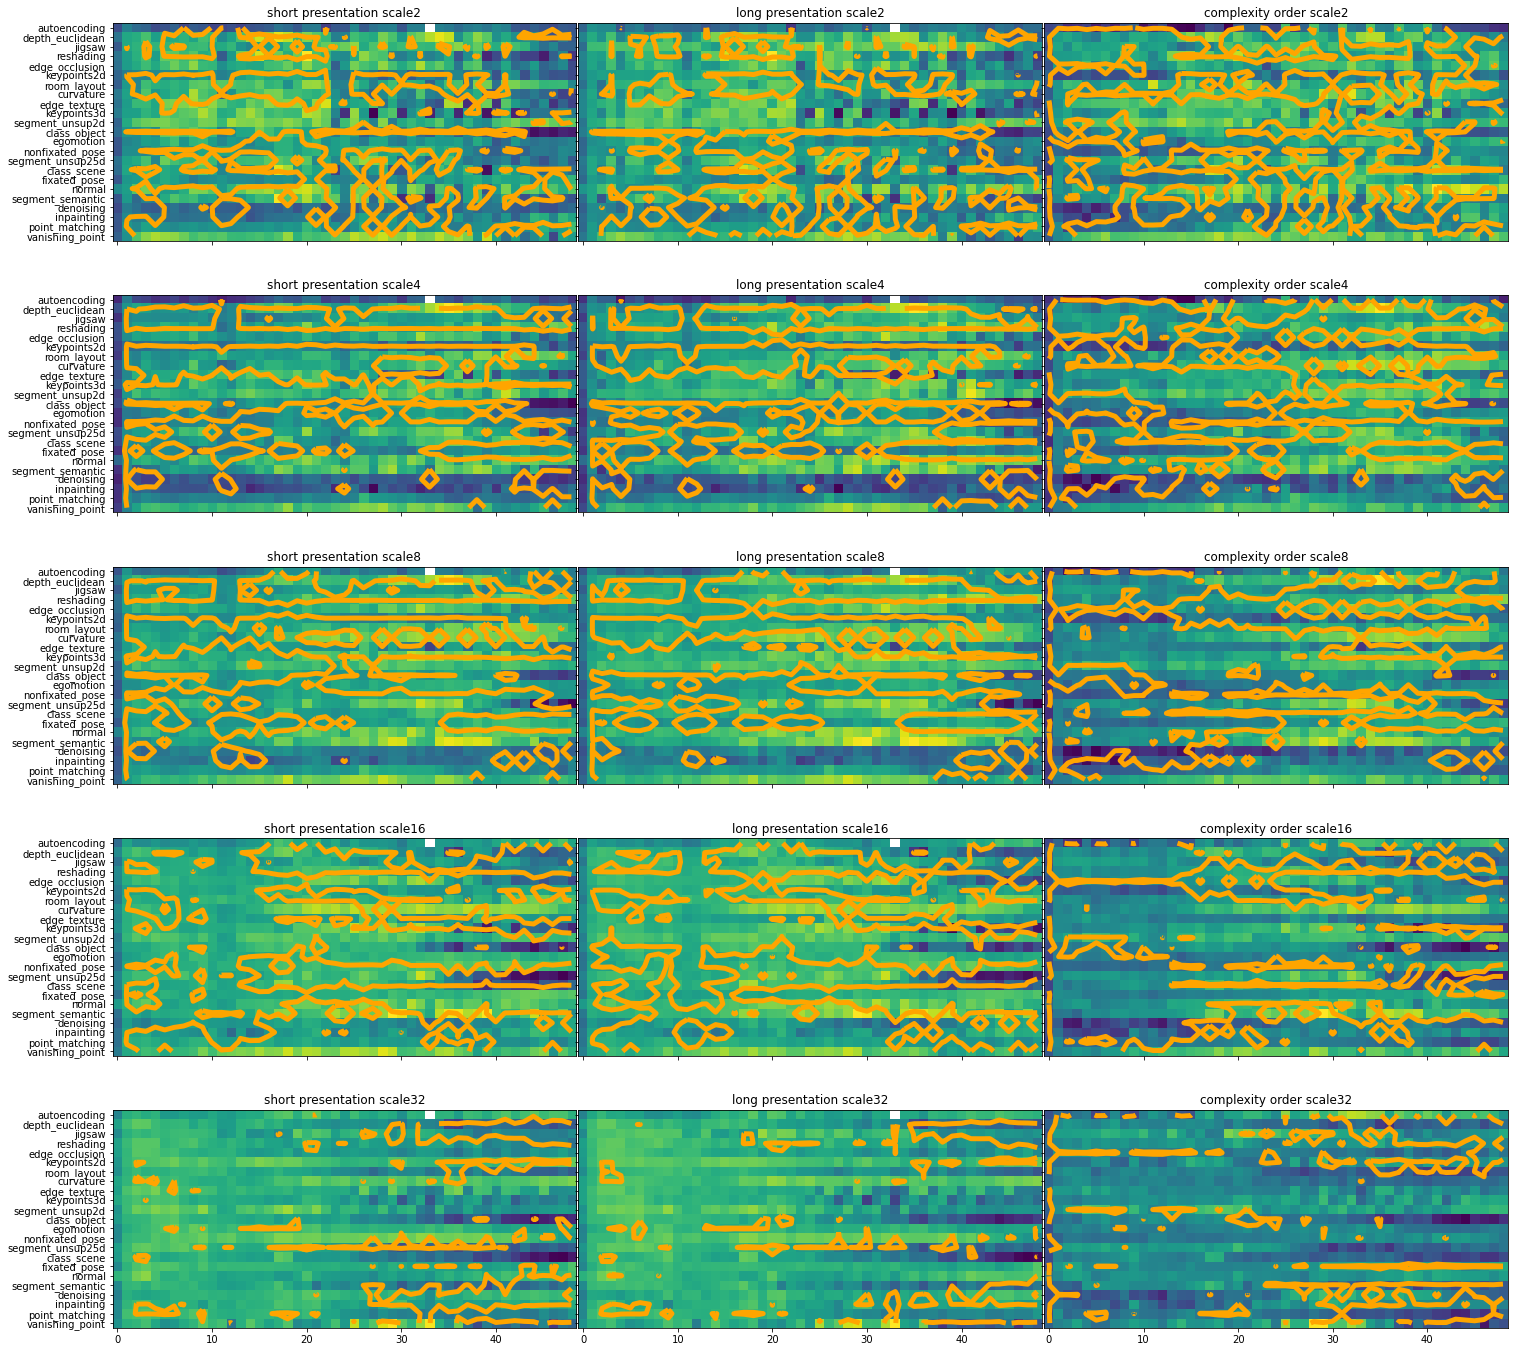

In [288]:
# scale x study grid of all-net heatmaps
fig, axes = plt.subplots(5, 3, figsize=(25,25), sharex=True,sharey=True)

for idsc, scale in enumerate(SCALE_NAMES):
    for idst, study in enumerate(STUDY_NAMES):
        corr= df_ib.loc[(slice(None), study,scale),:].droplevel(['scale','study'])
        p   = df_p.loc[(slice(None), study,scale),:].droplevel(['scale','study'])

        ax = axes[idsc,idst]
        ax.imshow(corr)
        ax.contour(p, levels=[0.05], colors='orange', linewidths=5, corner_mask = False)

        ax.set_yticks(range(len(corr.index)))
        ax.set_yticklabels(corr.index)
        ax.set_title(study + ' ' + scale)

plt.subplots_adjust(hspace=0.0, wspace=.005)

In [145]:
data = np.pad(np.random.random((10, 10)), 1)
data.shape

(12, 12)

In [180]:
data = np.random.random((10, 10))

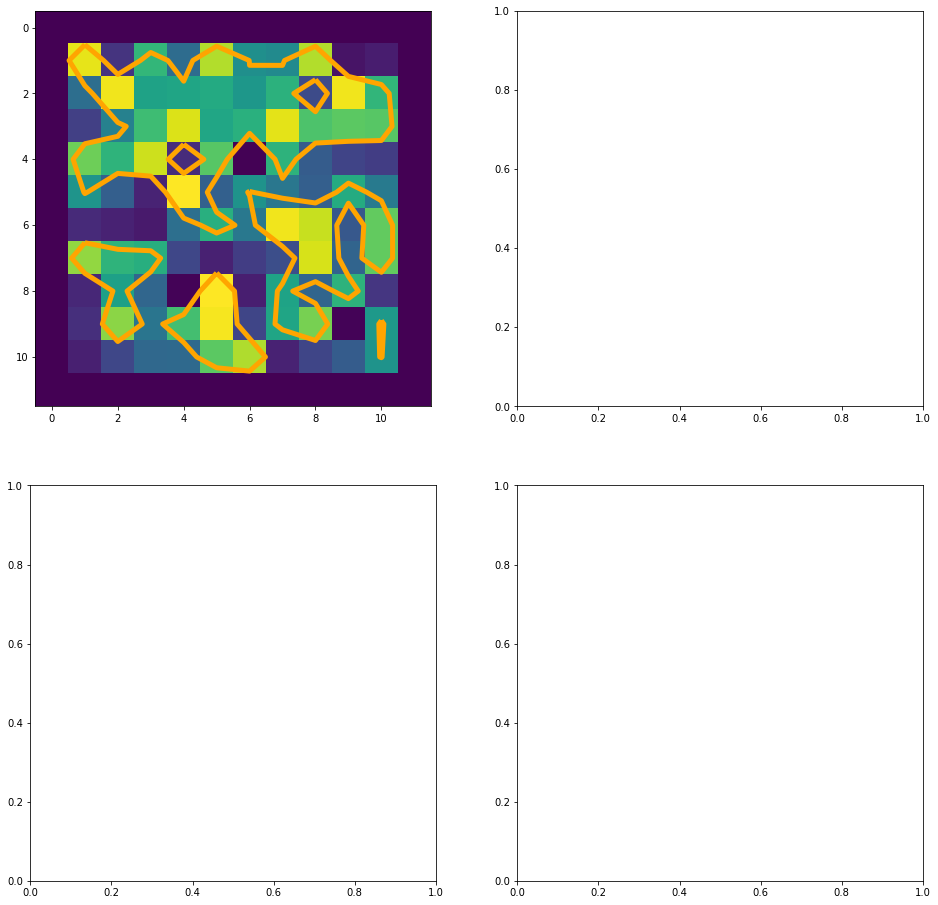

In [209]:
#data = np.pad(np.random.random((10, 10)), 1)
fig, ax = plt.subplots(2,2, figsize = (16,16))

# Example significance mask (True for significant, False for not)
# Let's assume that any value greater than 0.8 is significant
significance_mask = data > 0.8

# Plotting the heatmap
ax[0,0].imshow(data, cmap='viridis')

# Overlay the contours for significance
ax[0,0].contour(data, levels=[.5], colors='orange', linewidths=5, corner_mask = False)

# Add colorbar
#plt.colorbar()

# Show the plot
plt.show()


# blocked

In [ ]:
# load blocked integration correlation
data_list = []


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(DATA_PATH, model_name, study_name, scale_name, 'ib_correlations.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr"}) for data in data_list]

# combine into one DataFrame
dfc = pd.concat(data_list).reset_index(drop=True).set_index(['model','study','scale','layer'])
dfc

In [ ]:
# load blocked integration 
data_list = []


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(DATA_PATH, model_name, study_name, scale_name, 'ib_correlations_pvalues.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr pvalue"}) for data in data_list]

# combine into one DataFrame
dfp = pd.concat(data_list).reset_index(drop=True).set_index(['model','study','scale','layer'])
dfp